In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from cv2 import resize
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In tensorflow, we can easily load image datasets with directory structure like this using `image_dataset_from_directory`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MyDrive  Shareddrives


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from cv2 import resize
from glob import glob
import tensorflow as tf

In [ ]:
img_height = 224
img_width = 224


train_ds = tf.keras.utils.image_dataset_from_directory(
  r'/content/drive/MyDrive/animals',
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  r'/content/drive/MyDrive/animals',
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)


Found 5540 files belonging to 90 classes.
Using 4432 files for training.
Found 5540 files belonging to 90 classes.
Using 1108 files for validation.


Let's load VGG-16 pretrained on imagenet as the base model.

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False # Freeze VGG-16 for now

58889256/58889256 [==============================] - 0s 0us/step


Add own output layers to form a complete model.

In [ ]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming you have a tensor 'input_tensor' and a model 'model'
input_tensor = torch.tensor([1, 2, 3])  # Example tensor
model = torch.nn.Linear(10, 5)  # Example model

input_tensor = input_tensor.to(device)
model = model.to(device)

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(90)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train the fully-connected layer.

In [ ]:
num_epochs = 10
model.fit(train_ds, validation_data=val_ds, epochs=num_epochs,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=2,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
139/139 [==============================] - 1336s 9s/step - loss: 11.7713 - accuracy: 0.1137 - val_loss: 3.6939 - val_accuracy: 0.4070
Epoch 2/10
139/139 [==============================] - 39s 271ms/step - loss: 4.4180 - accuracy: 0.4016 - val_loss: 2.0261 - val_accuracy: 0.6155
Epoch 3/10
139/139 [==============================] - 37s 258ms/step - loss: 2.5621 - accuracy: 0.5835 - val_loss: 1.5215 - val_accuracy: 0.7148
Epoch 4/10
139/139 [==============================] - 37s 257ms/step - loss: 1.7419 - accuracy: 0.6722 - val_loss: 1.2453 - val_accuracy: 0.7798
Epoch 5/10
139/139 [==============================] - 40s 276ms/step - loss: 1.2381 - accuracy: 0.7529 - val_loss: 1.1790 - val_accuracy: 0.7915
Epoch 6/10
139/139 [==============================] - 38s 262ms/step - loss: 0.9940 - accuracy: 0.7881 - val_loss: 1.1233 - val_accuracy: 0.7978
Epoch 7/10
139/139 [==============================] - 40s 276ms/step - loss: 0.8166 - accuracy: 0.8157 - val_loss: 1.0244 - val_ac

If output layer is showing good result, now we unfreeze part of the VGG-16 to do fine-tuning.

In [ ]:
# fine tuning
base_model.trainable = True
for layer in base_model.layers[:14]:
    layer.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), # use a lower learning rate when fine-tuning
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
num_epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=2,
            verbose=1,
        )
    ]
)

Epoch 1/5
139/139 [==============================] - 42s 270ms/step - loss: 0.7603 - accuracy: 0.7881 - val_loss: 0.8066 - val_accuracy: 0.8150
Epoch 2/5
139/139 [==============================] - 38s 266ms/step - loss: 0.3520 - accuracy: 0.8973 - val_loss: 0.6808 - val_accuracy: 0.8475
Epoch 3/5
139/139 [==============================] - 39s 269ms/step - loss: 0.2247 - accuracy: 0.9305 - val_loss: 0.7200 - val_accuracy: 0.8294
Epoch 4/5
139/139 [==============================] - 38s 266ms/step - loss: 0.1497 - accuracy: 0.9546 - val_loss: 0.6963 - val_accuracy: 0.8583
Epoch 4: early stopping


After training, choose a random picture and see its prediction.

In [ ]:
img_path_list = glob(r'/content/drive/MyDrive/animals/tiger/*.jpg')
print(img_path_list)

['/content/drive/MyDrive/animals/tiger/073cf8732d.jpg', '/content/drive/MyDrive/animals/tiger/7be18d2d89.jpg', '/content/drive/MyDrive/animals/tiger/048cbe616d.jpg', '/content/drive/MyDrive/animals/tiger/05e416d392.jpg', '/content/drive/MyDrive/animals/tiger/0a5f5db460.jpg', '/content/drive/MyDrive/animals/tiger/0ce688e813.jpg', '/content/drive/MyDrive/animals/tiger/0aadbd5936.jpg', '/content/drive/MyDrive/animals/tiger/0f5be6eac8.jpg', '/content/drive/MyDrive/animals/tiger/0fdebd9663.jpg', '/content/drive/MyDrive/animals/tiger/10dc291203.jpg', '/content/drive/MyDrive/animals/tiger/1e821d2ec6.jpg', '/content/drive/MyDrive/animals/tiger/15b4abdb66.jpg', '/content/drive/MyDrive/animals/tiger/18ffb9a228.jpg', '/content/drive/MyDrive/animals/tiger/20ba7edcc3.jpg', '/content/drive/MyDrive/animals/tiger/21a3753e48.jpg', '/content/drive/MyDrive/animals/tiger/2c75c39ece.jpg', '/content/drive/MyDrive/animals/tiger/2a160681b2.jpg', '/content/drive/MyDrive/animals/tiger/2cc98f8b66.jpg', '/content

1/1 [==============================] - 0s 57ms/step
/content/drive/MyDrive/animals/bear/22ea4eea68.jpg most likely belongs to bear with a 100.00 percent confidence.


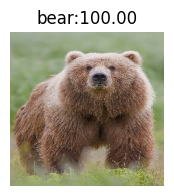

In [ ]:
import random
from glob import glob

# Assuming multiple images are in '/content/drive/MyDrive/'
img_path_list = glob('/content/drive/MyDrive/animals/bear/*.jpg')  # Modify the pattern if necessary

if img_path_list:
    img_name = random.choice(img_path_list)
    img = tf.keras.utils.load_img(
        img_name, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "{} most likely belongs to {} with a {:.2f} percent confidence."
        .format(img_name, train_ds.class_names[np.argmax(score)], 100 * np.max(score))
    )

    plt.figure(figsize=(2, 2))
    plt.imshow((img_array[0].numpy()).astype('uint8'))
    plt.title("{}:{:.2f}".format(train_ds.class_names[np.argmax(score)], 100 * np.max(score)))
    plt.axis('off')
    plt.show()

